In [1]:
### Installing dependencies for preprocessing of images 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Helper Functions

In [4]:
import numpy as np 
import pandas as pd 
from plotly.offline import init_notebook_mode, iplot
import os
from os import listdir
import plotly.graph_objs as go
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model


### Loading Images

In [9]:
image_dir="/content/drive/MyDrive/DATASETS/brain-tumor-dataset-253/brain_tumor_dataset/"

### Making directory for augmented images

**A directory is formed using os.makedirs() function for augmented images(yes/ no). Note- custom directory is obtained in outputs folder.**

In [10]:
os.makedirs('/content/augmented-images', exist_ok = True)
os.makedirs('/content/augmented-images/yes', exist_ok = True)
os.makedirs('/content/augmented-images/no', exist_ok = True)


augmented_data_path ='/content/augmented-images/'

augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_SIZE = (224,224)

## Augmentation of images 
**About the data:
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous andno contains 98 Brain MRI Images that are non-tumorous.**

In [11]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [12]:
dir = os.listdir('/content/augmented-images/yes') 

if len(dir) == 0: 

    # augment data for the examples with label equal to 'yes' representing tumurous examples
    augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
    # augment data for the examples with label equal to 'no' representing non-tumurous examples
    augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')
else:
    print(len(dir))

In [13]:
def load_data(dir_list):

    # load all images in a directory
    X = []
    y = []
#     image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
#             image = crop_brain_contour(image, plot=False)
#             image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
#             # normalize values
#             image = image / 255.
#             # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [14]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [15]:
X_train, y_train = load_data([augmented_yes, augmented_no])

Number of examples is: 2063
X shape is: (2063,)
y shape is: (2063, 1)


<ipython-input-13-b0a3ada68dc4>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



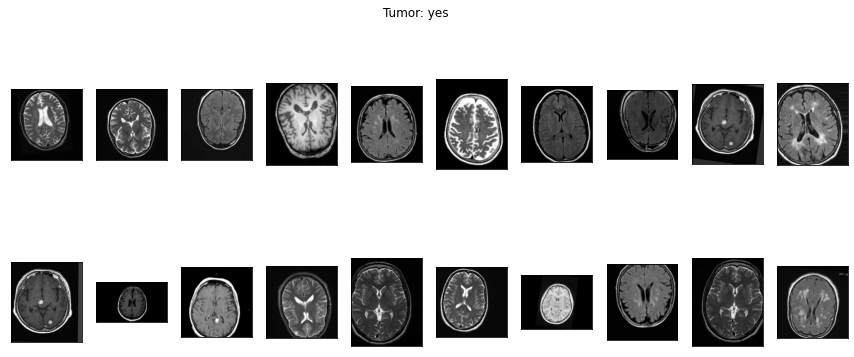

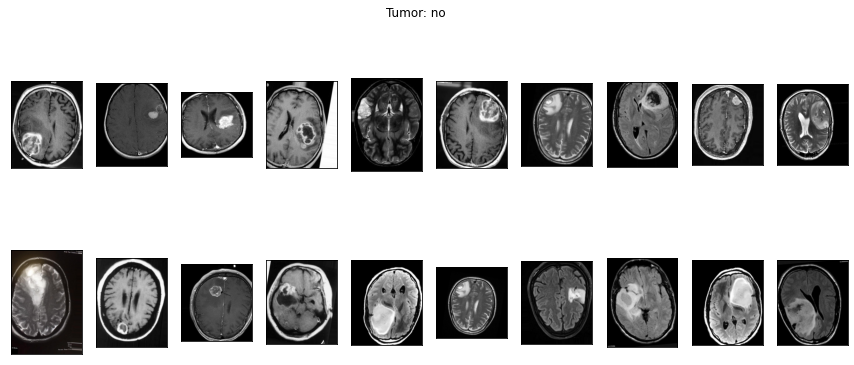

In [16]:
plot_samples(X_train, y_train, ['yes','no'], 20)

## Preprocessing the data

In order to crop the specific part of the image containing tumour,cropping technique via OpenCv is used, the details can be found here.[How to find extreme points in OpenCv?](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

## After applying the cropping function

In [42]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Canny Edge Detection Algortihm from OpenCV
    thresh0 = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh0, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        new_image = image[y:y+h, x:x+w]
        break        

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

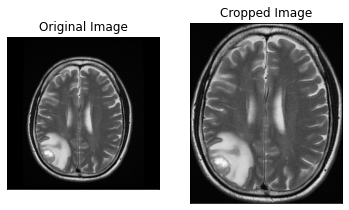

In [43]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [19]:
def Croping_Data(train):

    # load all images in a directory
    X = []
    y = []
    
    for img in train:
        image = crop_brain_contour(img, plot=False)
        X.append(image)
                
    X = np.array(X)
    
    return X

In [20]:
X = Croping_Data(X_train)

<ipython-input-19-5841781f4295>:11: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



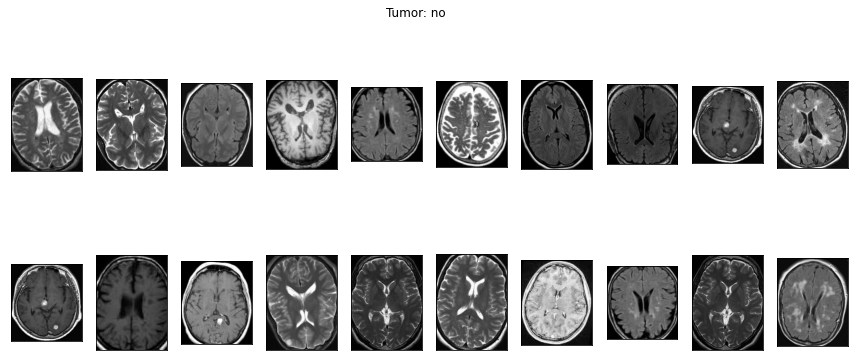

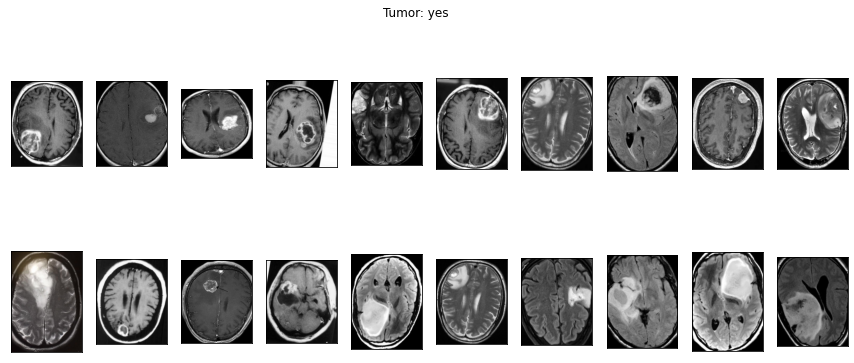

In [21]:
plot_samples(X, y_train, ['no','yes'], 20)

In [22]:
def Resize_Data(train):

    # load all images in a directory
    X = []
    y = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        # normalize values
        image = image / 255.
        # convert image to numpy array and append it to X
        X.append(image)
                
    X = np.array(X)
    
    return X

In [23]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = Resize_Data(X_train)
y = y_train



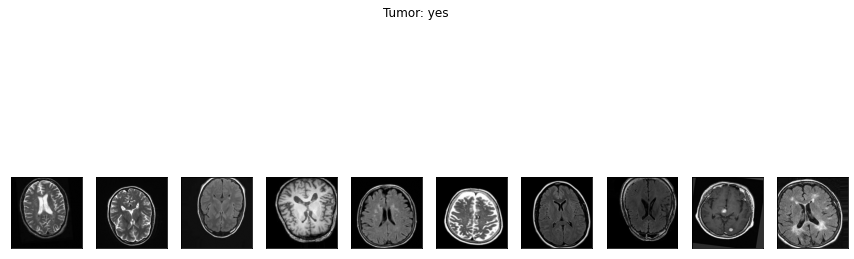

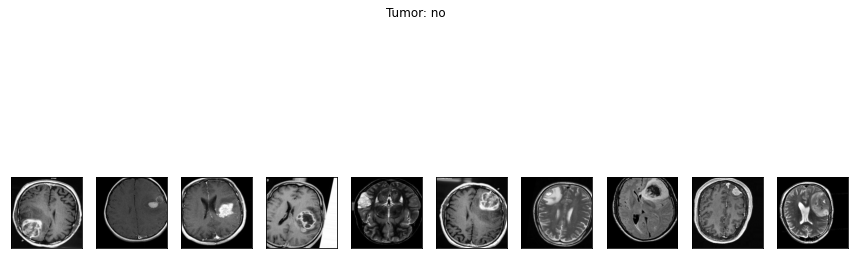

In [24]:
plot_samples(X, y_train, ['yes','no'],10)

## Visualization of Data

In [25]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [27]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1444
number of validation examples = 310
number of test examples = 309


In [28]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [29]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((3, 3))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(0.05)(X)
    X = MaxPooling2D((4, 4))(X) 
    #X = MaxPooling2D((4, 4))(X)  
    
    X = Conv2D(16, (3, 3), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.05)(X)
    X = MaxPooling2D((2, 2))(X)
   # X = MaxPooling2D((2, 2))(X)
    X = Flatten()(X) 
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.05)(X)
    X = Dense(1, activation='sigmoid')(X) 
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [30]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 246, 246, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 240, 240, 32)      128       
                                                                 
 activation (Activation)     (None, 240, 240, 32)      0         
                                                                 
 dropout (Dropout)           (None, 240, 240, 32)      0         
                                                             

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
46/46 [==============================] - 12s 86ms/step - loss: 1.0704 - accuracy: 0.5519 - val_loss: 0.6656 - val_accuracy: 0.5000
Epoch 2/10
46/46 [==============================] - 3s 73ms/step - loss: 0.6220 - accuracy: 0.6745 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 3/10
46/46 [==============================] - 3s 73ms/step - loss: 0.5774 - accuracy: 0.7417 - val_loss: 0.8175 - val_accuracy: 0.5000
Epoch 4/10
46/46 [==============================] - 3s 73ms/step - loss: 0.5524 - accuracy: 0.7798 - val_loss: 1.0415 - val_accuracy: 0.5000
Epoch 5/10
46/46 [==============================] - 3s 73ms/step - loss: 0.5463 - accuracy: 0.7715 - val_loss: 0.9997 - val_accuracy: 0.5000
Epoch 6/10
46/46 [==============================] - 3s 73ms/step - loss: 0.4986 - accuracy: 0.8227 - val_loss: 0.8242 - val_accuracy: 0.5065
Epoch 7/10
46/46 [==============================] - 3s 73ms/step - loss: 0.4833 - accuracy: 0.8186 - val_loss: 0.6664 - val_accuracy: 0.6129
Epoch 8/10
4

In [32]:
history = model.history.history

### Plotting of Accuracy

In [33]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

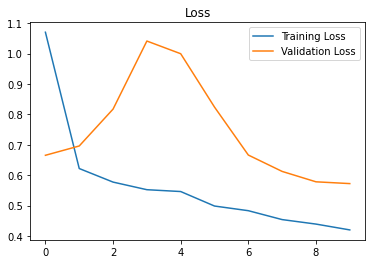

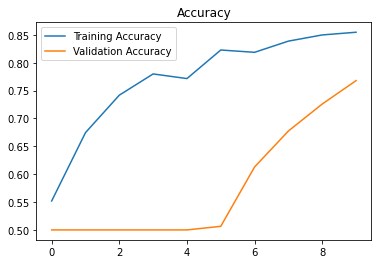

In [34]:
plot_metrics(history)

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

10/10 [==============================] - 0s 24ms/step
Val Accuracy = 0.77


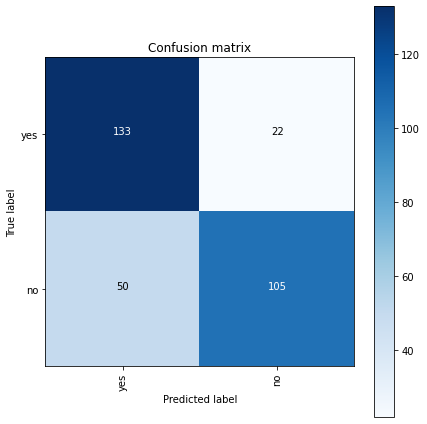

In [36]:
labels = ['yes','no']
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

10/10 [==============================] - 0s 48ms/step
Test Accuracy = 0.80


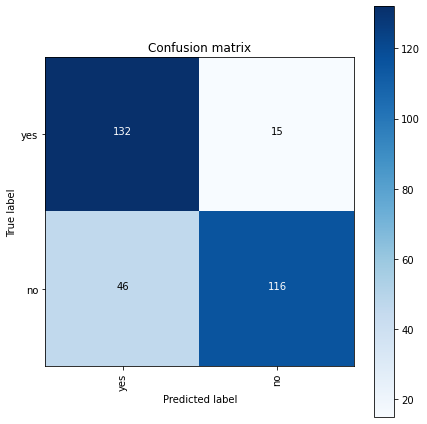

In [37]:
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

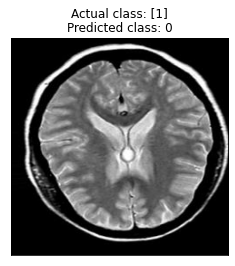

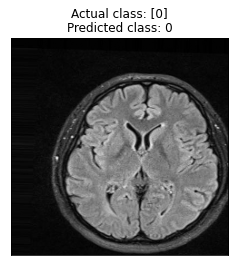

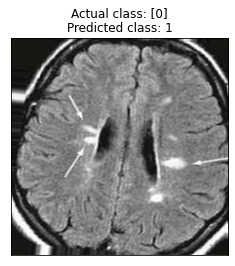

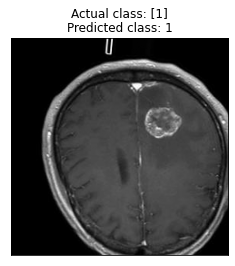

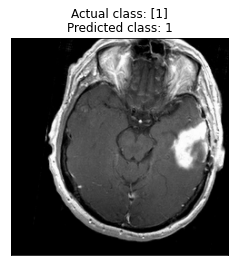

In [38]:
for i in range(5):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()